In [ ]:
pip install torch torchvision albumentations opencv-python matplotlib


In [ ]:
pip install rasterio

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt


In [25]:
import rasterio
import numpy as np
import torch
from torch.utils.data import Dataset

class FloodDataset(Dataset):
    def __init__(self, img_dir, ann_dir, img_size=224):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.img_size = img_size
        self.image_files = sorted(os.listdir(img_dir))
        self.mask_files = sorted(os.listdir(ann_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        mask_path = os.path.join(self.ann_dir, self.mask_files[idx])

        # Use rasterio to read .tif files
        with rasterio.open(img_path) as img_src:
            img = img_src.read([1, 2])  # Read specific bands (e.g., band 1 and band 2)
        
        with rasterio.open(mask_path) as mask_src:
            mask = mask_src.read(1)  # Read the first band for the mask
        
        # Normalize the image
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        
        # Resize the image and mask
        img = np.transpose(img, (1, 2, 0))  # Change to HWC format
        img = np.resize(img, (self.img_size, self.img_size, img.shape[-1]))
        mask = np.resize(mask, (self.img_size, self.img_size))

        # Convert to tensors
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # CHW format
        #mask_tensor = torch.tensor(mask, dtype=torch.long)
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension and convert to Float

        return img_tensor, mask_tensor


In [26]:
import os

root_dir = "dataset2"  # Path to your dataset
img_size = 224

# Paths
train_img_dir = os.path.join(root_dir, "images", "train")
train_ann_dir = os.path.join(root_dir, "annotations", "train")
val_img_dir = os.path.join(root_dir, "images", "val")
val_ann_dir = os.path.join(root_dir, "annotations", "val")
test_img_dir = os.path.join(root_dir, "images", "test")
test_ann_dir = os.path.join(root_dir, "annotations", "test")

print(f"Train image directory exists: {os.path.exists(train_img_dir)}")
print(f"Train annotation directory exists: {os.path.exists(train_ann_dir)}")
print(f"Validation image directory exists: {os.path.exists(val_img_dir)}")
print(f"Validation annotation directory exists: {os.path.exists(val_ann_dir)}")


Train image directory exists: True
Train annotation directory exists: True
Validation image directory exists: True
Validation annotation directory exists: True


In [27]:
# Initialize datasets
train_dataset = FloodDataset(img_dir=train_img_dir, ann_dir=train_ann_dir, img_size=img_size)
val_dataset = FloodDataset(img_dir=val_img_dir, ann_dir=val_ann_dir, img_size=img_size)
test_dataset = FloodDataset(img_dir=test_img_dir, ann_dir=test_ann_dir, img_size=img_size)


In [28]:
from torch.utils.data import DataLoader

batch_size = 4
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [29]:
# Test train_loader
for images, masks in train_loader:
    print(f"Train batch - Images shape: {images.shape}, Masks shape: {masks.shape}")
    break

# Test val_loader
for images, masks in val_loader:
    print(f"Validation batch - Images shape: {images.shape}, Masks shape: {masks.shape}")
    break


Train batch - Images shape: torch.Size([4, 2, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Validation batch - Images shape: torch.Size([4, 2, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])


In [30]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Load a batch and print its shape
for batch in train_loader:
    images, masks = batch
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")
    break


Images shape: torch.Size([4, 2, 224, 224])
Masks shape: torch.Size([4, 1, 224, 224])


In [31]:
import os
from glob import glob

# Check the train directory
train_images = glob(os.path.join("/home/mehdih/codes/prithvi/prithvi_finetuning/dataset2/images/train", "*.tif"))
train_annotations = glob(os.path.join("/home/mehdih/codes/prithvi/prithvi_finetuning/dataset2/annotations/train", "*.tif"))

print(f"Number of train images: {len(train_images)}")
print(f"Number of train annotations: {len(train_annotations)}")

# Print a few file paths
print("Sample train image files:", train_images[:5])
print("Sample train annotation files:", train_annotations[:5])


Number of train images: 156
Number of train annotations: 156
Sample train image files: ['/home/mehdih/codes/prithvi/prithvi_finetuning/dataset2/images/train/Mississippi_4352_2816.tif', '/home/mehdih/codes/prithvi/prithvi_finetuning/dataset2/images/train/Mississippi_14336_2304.tif', '/home/mehdih/codes/prithvi/prithvi_finetuning/dataset2/images/train/Valencia_512_0.tif', '/home/mehdih/codes/prithvi/prithvi_finetuning/dataset2/images/train/Mississippi_13568_2304.tif', '/home/mehdih/codes/prithvi/prithvi_finetuning/dataset2/images/train/Valencia_2048_2304.tif']
Sample train annotation files: ['/home/mehdih/codes/prithvi/prithvi_finetuning/dataset2/annotations/train/Mississippi_4352_2816.tif', '/home/mehdih/codes/prithvi/prithvi_finetuning/dataset2/annotations/train/Mississippi_14336_2304.tif', '/home/mehdih/codes/prithvi/prithvi_finetuning/dataset2/annotations/train/Valencia_512_0.tif', '/home/mehdih/codes/prithvi/prithvi_finetuning/dataset2/annotations/train/Mississippi_13568_2304.tif', 

In [32]:
from torch.utils.data import DataLoader

# Initialize dataset and loader
dataset = FloodDataset(
    img_dir="/home/mehdih/codes/prithvi/prithvi_finetuning/dataset2/images/train",
    ann_dir="/home/mehdih/codes/prithvi/prithvi_finetuning/dataset2/annotations/train",
    img_size=224
)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Load a batch and print its shape
for batch in loader:
    images, masks = batch
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")
    break


Images shape: torch.Size([4, 2, 224, 224])
Masks shape: torch.Size([4, 1, 224, 224])


In [33]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=3, padding=1),  # 2 input channels
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1),  # Output to 1 channel (binary segmentation)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.decoder(x)
        return x


In [34]:
# Check a batch of data
for images, masks in train_loader:
    print(f"Image shape: {images.shape}")  # Expected: [batch_size, 2, height, width]
    print(f"Mask shape: {masks.shape}")   # Expected: [batch_size, height, width]
    break


Image shape: torch.Size([4, 2, 224, 224])
Mask shape: torch.Size([4, 1, 224, 224])


In [ ]:
#not this
def train_model(model, train_loader, val_loader, device, epochs=30):
    model.to(device)
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            outputs = outputs
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                outputs = outputs
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


In [35]:
from torch.optim.lr_scheduler import CosineAnnealingLR

scheduler = CosineAnnealingLR(optimizer, T_max=epochs)


In [46]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# Initialize the optimizer and scheduler outside the function
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

def train_model(model, train_loader, val_loader, device, epochs=30):
    model.to(device)
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0  # Initialize train_loss at the start of the epoch
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()  # Accumulate loss within the epoch

        scheduler.step()  # Update learning rate after each epoch

        train_losses.append(train_loss / len(train_loader))  # Append average loss for the epoch

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))  # Append average validation loss
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


In [47]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [48]:
model = UNet()


In [49]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.0001)

# Send model to device
model.to(device)


UNet(
  (encoder): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    (3): Sigmoid()
  )
)

Epoch 1/30, Train Loss: 0.5322, Val Loss: 0.5256
Epoch 2/30, Train Loss: 0.5052, Val Loss: 0.4932
Epoch 3/30, Train Loss: 0.4646, Val Loss: 0.4480
Epoch 4/30, Train Loss: 0.4425, Val Loss: 0.4380
Epoch 5/30, Train Loss: 0.4291, Val Loss: 0.4374
Epoch 6/30, Train Loss: 0.4357, Val Loss: 0.4322
Epoch 7/30, Train Loss: 0.4268, Val Loss: 0.4249
Epoch 8/30, Train Loss: 0.4135, Val Loss: 0.4180
Epoch 9/30, Train Loss: 0.4033, Val Loss: 0.4087
Epoch 10/30, Train Loss: 0.3994, Val Loss: 0.4033
Epoch 11/30, Train Loss: 0.3972, Val Loss: 0.4011
Epoch 12/30, Train Loss: 0.3943, Val Loss: 0.4007
Epoch 13/30, Train Loss: 0.3908, Val Loss: 0.3964
Epoch 14/30, Train Loss: 0.3870, Val Loss: 0.4049
Epoch 15/30, Train Loss: 0.3891, Val Loss: 0.3943
Epoch 16/30, Train Loss: 0.3838, Val Loss: 0.3956
Epoch 17/30, Train Loss: 0.3811, Val Loss: 0.3954
Epoch 18/30, Train Loss: 0.3823, Val Loss: 0.3914
Epoch 19/30, Train Loss: 0.3799, Val Loss: 0.3918
Epoch 20/30, Train Loss: 0.3805, Val Loss: 0.3932
Epoch 21/

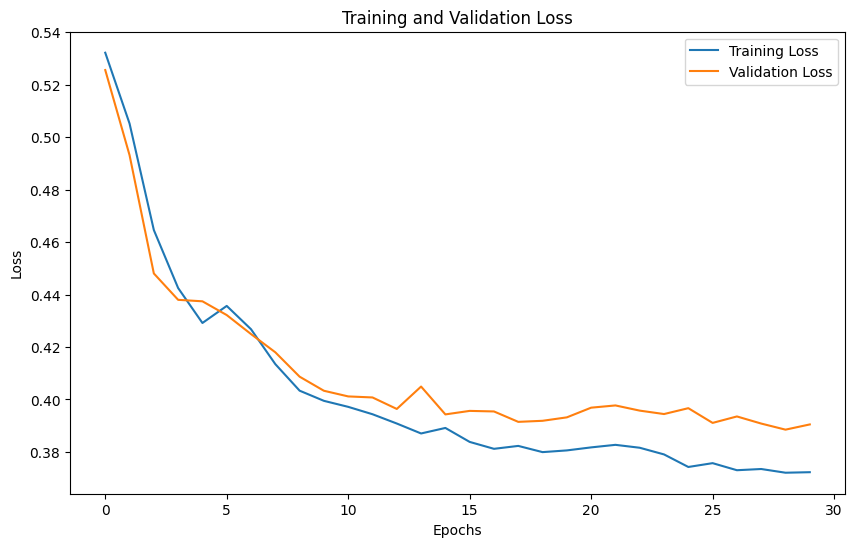

In [50]:
# Train the model
epochs = 30
train_losses, val_losses = train_model(model, train_loader, val_loader, device, epochs=epochs)

# Plot the training and validation loss
plot_losses(train_losses, val_losses)
